<a href="https://colab.research.google.com/github/kapilanranjan58-dot/Bigdata-And-Visualization01/blob/main/SuperStoreSalesAnalytics01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup & Data Ingestion

In [ ]:
# Ranjan Kapilan
# Script to initialize a Spark session and import functions
from pyspark.sql import SparkSession, functions as F

# Create Spark App
# Initialize Spark session
spark = SparkSession.builder.appName("Superstores Sales Analytics").getOrCreate()

In [ ]:
# Ranjan Kapilan
# Load the dataset
df = spark.read.format("csv").load("/content/SuperstoreSalesDataset.csv",header=True, inferSchema=True)
df.show(5, truncate=False)
print(f"Total records: {df.count()}")

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+-----------------------------------------------------------+--------+
|Row ID|Order ID      |Order Date|Ship Date |Ship Mode     |Customer ID|Customer Name  |Segment  |Country      |City           |State     |Postal Code|Region|Product ID     |Category       |Sub-Category|Product Name                                               |Sales   |
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+-----------------------------------------------------------+--------+
|1     |CA-2017-152156|2017-08-11|11/11/2017|Second Class  |CG-12520   |Claire Gute    |Consumer |United States|Henderson      |Kentucky  |42420      |South |FUR-BO-10001798|Furnitu

In [ ]:
from pyspark.sql.functions import col, lit

In [ ]:
df.select("Sales").distinct().show(20, truncate=False)


+-------+
|Sales  |
+-------+
|1.248  |
|7.16   |
|258.072|
|961.48 |
|647.84 |
|78.272 |
|105.42 |
|119.8  |
|406.6  |
|197.97 |
|79.14  |
|251.79 |
|219.84 |
|710.832|
|526.45 |
|108.576|
|123.136|
|203.92 |
|35.568 |
|767.214|
+-------+
only showing top 20 rows


In [ ]:
from pyspark.sql.functions import col, when, regexp_replace

df = df.withColumn(
    "Sales",
    when(
        col("Sales").rlike("^[0-9.]+$"),
        col("Sales").cast("double")
    ).otherwise(None)
)


In [ ]:
df = df.withColumn(
    "Sales",
    regexp_replace(col("Sales"), ",", "").cast("double")
)


Meta-data Table

In [ ]:
# import necessary functions
from pyspark.sql.functions import col, count, sum

metadata = []

for col_name, dtype in df.dtypes:
    distinct_count = df.select(col_name).distinct().count()
    null_count = df.filter(col(col_name).isNull()).count()

    metadata.append((col_name, dtype, distinct_count, null_count))

# Meta Data
metadata_df = spark.createDataFrame(metadata, ["Attribute", "Data Type", "Distinct Values", "Missing Values"])

metadata_df.show(truncate=False)

+-------------+---------+---------------+--------------+
|Attribute    |Data Type|Distinct Values|Missing Values|
+-------------+---------+---------------+--------------+
|Row ID       |int      |9800           |0             |
|Order ID     |string   |4922           |0             |
|Order Date   |string   |1230           |0             |
|Ship Date    |string   |1326           |0             |
|Ship Mode    |string   |4              |0             |
|Customer ID  |string   |793            |0             |
|Customer Name|string   |793            |0             |
|Segment      |string   |3              |0             |
|Country      |string   |1              |0             |
|City         |string   |529            |0             |
|State        |string   |49             |0             |
|Postal Code  |int      |627            |11            |
|Region       |string   |4              |0             |
|Product ID   |string   |1861           |0             |
|Category     |string   |3     

Data Pre-Processing (Reducing, and Sorted DataFrame)

In [ ]:
from pyspark.sql.functions import (
    col, lit, round, year, month, datediff, try_to_timestamp, coalesce, trim, when
)

# --------------------------------------------------
# 1. Drop index column if it exists
# --------------------------------------------------
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0")

# --------------------------------------------------
# 2. Rename ONLY necessary columns
# --------------------------------------------------
df = df.withColumnRenamed("Order Date", "Order_Date") \
       .withColumnRenamed("Ship Date", "Ship_Date") \
       .withColumnRenamed("Sub-Category", "sub_category")

# --------------------------------------------------
# Add a step to handle string 'NULL' values in date columns
# --------------------------------------------------
df = df.withColumn(
    "Order_Date",
    when(trim(col("Order_Date")) == lit("NULL"), lit(None)).otherwise(col("Order_Date"))
).withColumn(
    "Ship_Date",
    when(trim(col("Ship_Date")) == lit("NULL"), lit(None)).otherwise(col("Ship_Date"))
)

# --------------------------------------------------
# 3. Convert date columns (SAFE – NO FORMAT STRING)
# --------------------------------------------------
df = df.withColumn(
    "Order_Date",
    coalesce(
        try_to_timestamp(trim(col("Order_Date")), lit("yyyy-MM-dd")),
        try_to_timestamp(trim(col("Order_Date")), lit("dd/MM/yyyy"))
    ).cast("date")
) \
.withColumn("Ship_Date", coalesce(
    try_to_timestamp(trim(col("Ship_Date")), lit("dd/MM/yyyy")),
    try_to_timestamp(trim(col("Ship_Date")), lit("yyyy-MM-dd")) # Added another format for robustness
).cast("date"))

# --------------------------------------------------
# 4. Cast and round sales
# --------------------------------------------------
df = df.withColumn("Sales", col("Sales").cast("double"))
df = df.withColumn("Sales", round(col("Sales"), 2))

# --------------------------------------------------
# 5. Extract date features
# --------------------------------------------------
df = df.withColumn("order_year", year(col("Order_Date"))) \
       .withColumn("order_month", month(col("Order_Date")))

# --------------------------------------------------
# 6. Calculate shipping days
# --------------------------------------------------
df = df.withColumn(
    "shipping_days",
    datediff(col("Ship_Date"), col("Order_Date"))
)

# --------------------------------------------------
# 7. Show cleaned data
# --------------------------------------------------
df.show(5, truncate=False)


+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+-----------------------------------------------------------+------+----------+-----------+-------------+
|Row ID|Order ID      |Order_Date|Ship_Date |Ship Mode     |Customer ID|Customer Name  |Segment  |Country      |City           |State     |Postal Code|Region|Product ID     |Category       |sub_category|Product Name                                               |Sales |order_year|order_month|shipping_days|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+-----------------------------------------------------------+------+----------+-----------+-------------+
|1     |CA-2017-152156|2017-08-11|2017-11-11|Second Class  |CG-12520   |Clai

Data Cleaning

In [ ]:
# Remove duplicate rows
print("Duplicate rows:", df.count() - df.distinct().count())
df = df.dropDuplicates()

# Remove negative sales
df = df.withColumn(
    "sales",
    F.when(F.col("sales") < 0, None).otherwise(F.col("sales"))
)

# Drop rows with NULL values
df = df.dropna()

# Sort by order_date
cleaned_df = df.orderBy(F.col("order_date").asc())

# Output
cleaned_df.show(2, truncate=False)
cleaned_df.printSchema()


Duplicate rows: 0
+------+--------------+----------+----------+------------+-----------+---------------+---------+-------------+------------+---------+-----------+------+---------------+---------------+------------+-----------------------------------------------+------+----------+-----------+-------------+
|Row ID|Order ID      |Order_Date|Ship_Date |Ship Mode   |Customer ID|Customer Name  |Segment  |Country      |City        |State    |Postal Code|Region|Product ID     |Category       |sub_category|Product Name                                   |sales |order_year|order_month|shipping_days|
+------+--------------+----------+----------+------------+-----------+---------------+---------+-------------+------------+---------+-----------+------+---------------+---------------+------------+-----------------------------------------------+------+----------+-----------+-------------+
|768   |CA-2015-162775|2015-01-13|2015-01-15|Second Class|CS-12250   |Chris Selesnick|Corporate|United States|Bo

In [ ]:
# Checking for duplicate rows
print("Duplicate rows:", df.count() - df.distinct().count())

# Remove duplicate rows
df = df.dropDuplicates()
print("Rows after dropping duplicates:", df.count())

# Check invalid numeric values (only sales is numeric)
num_cols = ["sales"]

for c in num_cols:
    print(c, df.filter(col(c) < 0).count())

# Remove invalid numeric values
for c in num_cols:
    df = df.withColumn(
        c,
        when(col(c) < 0, None).otherwise(col(c))
    )

print("Rows after cleaning invalid values:", df.count())

# Checking for missing values
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

# Removing rows with critical missing values
df = df.dropna()
print("Rows after dropping critical nulls:", df.count())

# Final checking for null values
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

# Sorted DataFrame (cleaned data, sorted by order_date ascending)
cleaned_df = df.orderBy(F.col("order_date").asc())

# New DataFrame
cleaned_df.show(2, truncate=False)
cleaned_df.printSchema()

Duplicate rows: 0
Rows after dropping duplicates: 6134
sales 0
Rows after cleaning invalid values: 6134
+------+--------+----------+---------+---------+-----------+-------------+-------+-------+----+-----+-----------+------+----------+--------+------------+------------+-----+----------+-----------+-------------+
|Row ID|Order ID|Order_Date|Ship_Date|Ship Mode|Customer ID|Customer Name|Segment|Country|City|State|Postal Code|Region|Product ID|Category|sub_category|Product Name|sales|order_year|order_month|shipping_days|
+------+--------+----------+---------+---------+-----------+-------------+-------+-------+----+-----+-----------+------+----------+--------+------------+------------+-----+----------+-----------+-------------+
|     0|       0|         0|        0|        0|          0|            0|      0|      0|   0|    0|          0|     0|         0|       0|           0|           0|    0|         0|          0|            0|
+------+--------+----------+---------+---------+--------

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

Data Transform

In [ ]:
# Categorical columns in your dataset
categorical_columns = [
    "Ship Mode", # Corrected from 'ship_mode'
    "Segment",
    "Country",
    "City",
    "State",
    "Region",
    "Category",
    "sub_category" # Corrected from 'sub-category'
]

# Numerical columns in your dataset
numerical_columns = ["sales"]

# Index the categorical columns
indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_index",
        handleInvalid="keep"
    )
    for col in categorical_columns
]

# One-hot encode the indexed columns
encoders = [
    OneHotEncoder(
        inputCol=f"{col}_index",
        outputCol=f"{col}_encoded",
        dropLast=False
    )
    for col in categorical_columns
]

# Create input columns for VectorAssembler
input_columns = [f"{col}_encoded" for col in categorical_columns] + numerical_columns

# Vectorize all features
assembler = VectorAssembler(
    inputCols=input_columns,
    outputCol="features"
)

In [ ]:
# Create the pipeline to transform the data
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline on cleaned data
data_model = pipeline.fit(cleaned_df)

# Transform the data
transformed_df = data_model.transform(cleaned_df)

# Preview transformed data
transformed_df.select("features").show(2, truncate=False)

+----------------------------------------------------------------------------+
|features                                                                    |
+----------------------------------------------------------------------------+
|(555,[0,5,9,26,483,528,532,536,554],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.44]) |
|(555,[1,6,9,163,508,530,532,536,554],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.64])|
+----------------------------------------------------------------------------+
only showing top 2 rows


In [ ]:
# Show transformed data
transformed_df.show(5, truncate=False)

# Print schema of transformed DataFrame
transformed_df.printSchema()


+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+-------------+----------+-----------+------+---------------+---------------+------------+-----------------------------------------------+------+----------+-----------+-------------+---------------+-------------+-------------+----------+-----------+------------+--------------+------------------+-----------------+---------------+---------------+-----------------+---------------+--------------+----------------+--------------------+------------------------------------------------------------------------------+
|Row ID|Order ID      |Order_Date|Ship_Date |Ship Mode     |Customer ID|Customer Name  |Segment  |Country      |City         |State     |Postal Code|Region|Product ID     |Category       |sub_category|Product Name                                   |sales |order_year|order_month|shipping_days|Ship Mode_index|Segment_index|Country_index|City_index|State_index|Region_index|Cat

Summary Statistics

In [ ]:
from pyspark.sql.functions import (
    sum as _sum,
    mean,
    stddev,
    skewness,
    kurtosis,
    lit,
    round
)

# Get all numeric columns (sales + indexed categorical columns)
stats_columns = [
    col_name for col_name, dtype in transformed_df.dtypes
    if dtype in ("int", "double")
]

# Select only numeric columns
stats_df = transformed_df.select(stats_columns)

# Calculate statistics
stats = []

for col_name in stats_columns:
    row = stats_df.select(
        lit(col_name).alias("Variable"),
        round(_sum(col_name), 2).alias("Sum"),
        round(mean(col_name), 2).alias("Mean"),
        round(stddev(col_name), 2).alias("StdDev"),
        round(skewness(col_name), 2).alias("Skewness"),
        round(kurtosis(col_name), 2).alias("Kurtosis")
    )
    stats.append(row)

# Union all results into one DataFrame
final_stats = stats[0]
for s in stats[1:]:
    final_stats = final_stats.union(s)

# Show final statistics
final_stats.show(truncate=False)


+------------------+------------+--------+-------+--------+--------+
|Variable          |Sum         |Mean    |StdDev |Skewness|Kurtosis|
+------------------+------------+--------+-------+--------+--------+
|Row ID            |3.0105621E7 |4907.99 |2825.53|0.01    |-1.19   |
|Postal Code       |3.45045753E8|56251.35|31935.7|-0.18   |-1.48   |
|sales             |1449327.88  |236.28  |653.12 |13.37   |316.08  |
|order_year        |1.23705E7   |2016.71 |1.13   |-0.27   |-1.33   |
|order_month       |50205.0     |8.18    |3.12   |-0.62   |-0.67   |
|shipping_days     |-14338.0    |-2.34   |62.14  |-1.19   |6.76    |
|Ship Mode_index   |4060.0      |0.66    |0.92   |1.14    |0.11    |
|Segment_index     |3959.0      |0.65    |0.76   |0.7     |-0.96   |
|Country_index     |0.0         |0.0     |0.0    |NULL    |NULL    |
|City_index        |376027.0    |61.3    |93.54  |2.01    |3.61    |
|State_index       |47462.0     |7.74    |9.46   |1.6     |2.03    |
|Region_index      |7441.0      |1

Correlation Analysis

In [ ]:
from pyspark.sql.functions import col, stddev, count
import builtins

# Target variable
target_variable = "sales"

# Identify numeric columns (int, double)
numeric_cols = [c for c, t in df.dtypes if t in ("int", "double")]

# Remove target from list
numeric_cols = [c for c in numeric_cols if c != target_variable]

correlation_results = []

for c in numeric_cols:
    # Check for zero variance
    if df.select(stddev(c)).collect()[0][0] == 0:
        print(f"Skipping column '{c}' because it has zero variance")
        continue

    corr_value = df.stat.corr(target_variable, c)

    if corr_value is not None:
        abs_corr = abs(corr_value)

        if abs_corr >= 0.8:
            strength = "Very Strong"
        elif abs_corr >= 0.6:
            strength = "Strong"
        elif abs_corr >= 0.4:
            strength = "Moderate"
        elif abs_corr >= 0.2:
            strength = "Weak"
        else:
            strength = "Very Weak"

        correlation_results.append(
            (c, builtins.round(corr_value, 2), strength)
        )

# Create DataFrame if results exist
if correlation_results:
    correlation_df = spark.createDataFrame(
        correlation_results,
        ["Variable", "Correlation", "Strength"]
    ).orderBy(col("Correlation").desc())
    correlation_df.show(truncate=False)
else:
    print("No valid correlations found.")


+-------------+-----------+---------+
|Variable     |Correlation|Strength |
+-------------+-----------+---------+
|shipping_days|0.01       |Very Weak|
|Row ID       |-0.0       |Very Weak|
|order_year   |-0.01      |Very Weak|
|order_month  |-0.01      |Very Weak|
|Postal Code  |-0.03      |Very Weak|
+-------------+-----------+---------+



In [ ]:
# import graph
import matplotlib.pyplot as plt

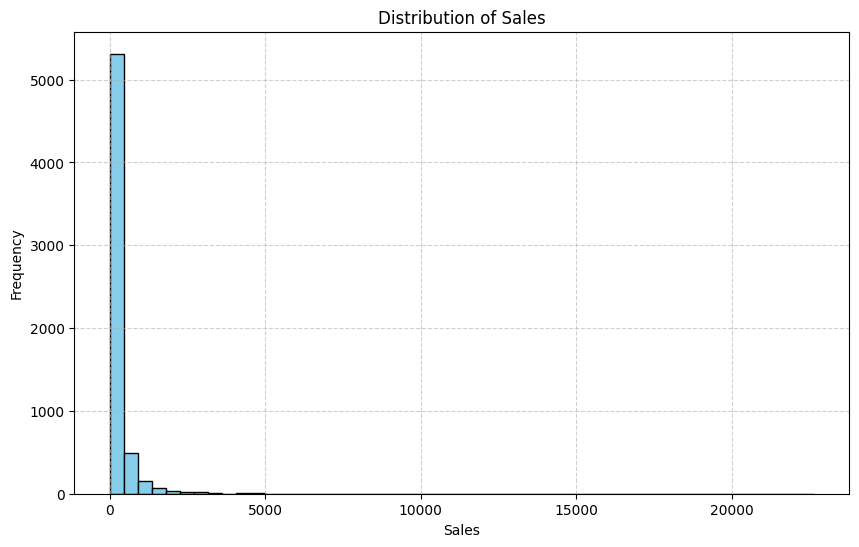

In [ ]:
# Convert Spark DataFrame column 'sales' to Pandas Series for plotting
sales_data = transformed_df.select("sales").toPandas()["sales"]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sales_data, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

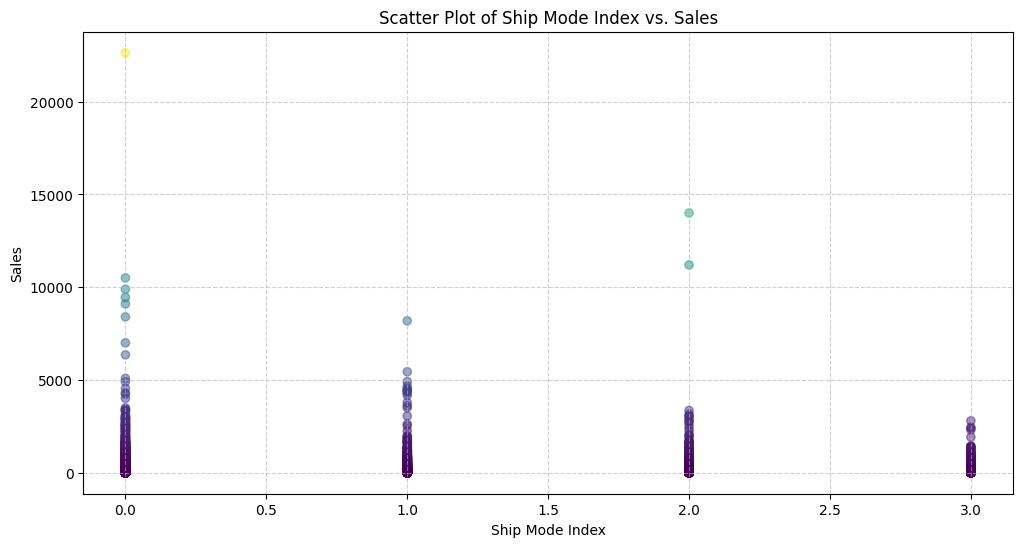

In [ ]:
# Convert Spark DataFrame columns to Pandas
plot_data = transformed_df.select("Ship Mode_index", "sales").toPandas()

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(
    plot_data["Ship Mode_index"],
    plot_data["sales"],
    c=plot_data["sales"],
    cmap="viridis",
    alpha=0.5
)
plt.title('Scatter Plot of Ship Mode Index vs. Sales')
plt.xlabel('Ship Mode Index')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

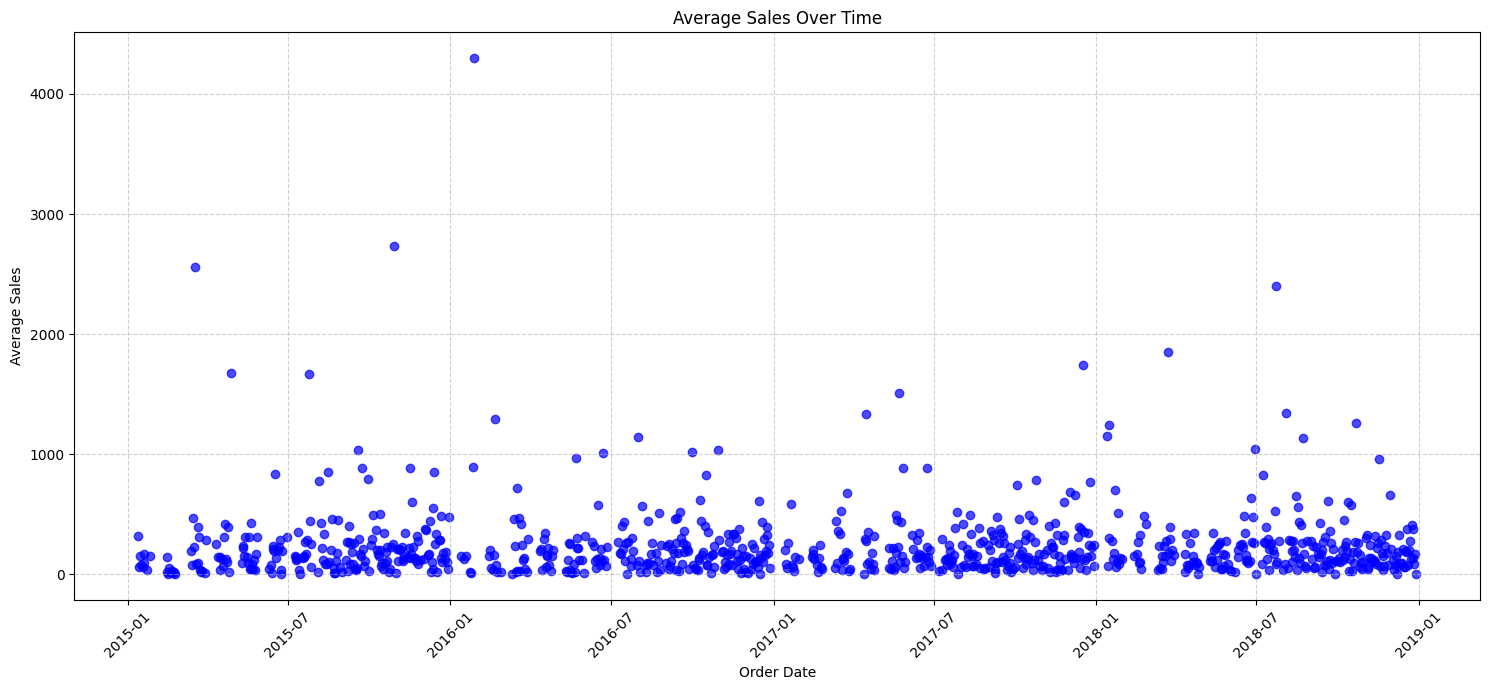

In [ ]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Calculate average sales per order_date
average_sales_by_date = transformed_df.groupBy("order_date").agg(
    avg("sales").alias("Average_Sales")
).orderBy("order_date")

# Convert to Pandas for plotting
plot_data_time_series = average_sales_by_date.toPandas()

# Plotting
plt.figure(figsize=(15, 7))
plt.scatter(
    plot_data_time_series["order_date"],
    plot_data_time_series["Average_Sales"],
    alpha=0.7,
    color='blue'
)
plt.title('Average Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Average Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Install and configure PySpark in Colab
!pip install pyspark --quiet

# Step 2: Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, expr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Step 3: Initialize Spark session
spark = SparkSession.builder.appName("SuperstorePrediction").getOrCreate()

# Step 4: Load dataset
df = spark.read.csv("/content/SuperstoreSalesDataset.csv", header=True, inferSchema=True)

# Safely cast 'sales' to double, handling malformed values as NULL
df = df.withColumn("sales", expr("try_cast(sales as double)"))

# Drop rows with any null values BEFORE pipeline processing
df = df.dropna()

# Step 5: Preprocessing
# List of categorical columns (corrected to match actual DataFrame column names)
categorical_cols = ["Category", "Sub-Category", "Region", "Segment", "Ship Mode"]

# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]

# One-hot encode indexed columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_cols]

# List of numerical columns (corrected to match actual DataFrame column names, removed 'Profit' and 'Quantity')
numeric_cols = ["sales"]

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=numeric_cols + [col+"_ohe" for col in categorical_cols],
    outputCol="features"
)

# Create Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit pipeline and transform dataset
pipeline_model = pipeline.fit(df)
data = pipeline_model.transform(df)

# Step 6: Define target variable (corrected to match actual DataFrame column name)
target = "sales"
final_data = data.select("features", target)

# Step 7: Train-test split (80%-20%)
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Step 8: Initialize models
lr = LinearRegression(featuresCol="features", labelCol=target)
rf = RandomForestRegressor(featuresCol="features", labelCol=target)
gbt = GBTRegressor(featuresCol="features", labelCol=target)

# Step 9: Train models
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)

# Step 10: Make predictions
lr_preds = lr_model.transform(test_data)
rf_preds = rf_model.transform(test_data)
gbt_preds = gbt_model.transform(test_data)

# Step 11: Evaluate models
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")

# Function to print metrics
def evaluate_model(preds, model_name):
    rmse = evaluator_rmse.evaluate(preds)
    r2 = evaluator_r2.evaluate(preds)
    mae = evaluator_mae.evaluate(preds)
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}\n")

# Step 12: Evaluate all models
evaluate_model(lr_preds, "Linear Regression")
evaluate_model(rf_preds, "Random Forest Regressor")
evaluate_model(gbt_preds, "Gradient Boosted Tree Regressor")

Linear Regression Performance:
RMSE: 0.00, R²: 1.00, MAE: 0.00

Random Forest Regressor Performance:
RMSE: 498.70, R²: 0.50, MAE: 94.16

Gradient Boosted Tree Regressor Performance:
RMSE: 508.19, R²: 0.48, MAE: 46.62



In [ ]:
# Export cleaned dataset to CSV (single file)
df.coalesce(1).write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("/content/CleanedSuperstoreSalesDataset")


In [ ]:
import os
import shutil

folder_path = "/content/CleanedSuperstoreSalesDataset"

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        shutil.move(
            os.path.join(folder_path, file),
            "/content/CleanedSuperstoreSalesDataset.csv"
        )


In [ ]:
from google.colab import files

files.download("/content/CleanedSuperstoreSalesDataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================
# Predictive Modeling – Data Splitting (PySpark)
# ================================

from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# --------------------------------
# 1. Select target and features
# --------------------------------
model_df = df.select(
    "Sales",
    "Category",
    "Sub-Category",
    "Region",
    "Ship Mode"
).dropna(subset=["Sales"])

# --------------------------------
# 2. Define categorical indexers
# --------------------------------
indexers = [
    StringIndexer(inputCol="Category", outputCol="Category_Index", handleInvalid="keep"),
    StringIndexer(inputCol="Sub-Category", outputCol="SubCategory_Index", handleInvalid="keep"),
    StringIndexer(inputCol="Region", outputCol="Region_Index", handleInvalid="keep"),
    StringIndexer(inputCol="Ship Mode", outputCol="ShipMode_Index", handleInvalid="keep")
]

# --------------------------------
# 3. One-Hot Encoding
# --------------------------------
encoder = OneHotEncoder(
    inputCols=[
        "Category_Index",
        "SubCategory_Index",
        "Region_Index",
        "ShipMode_Index"
    ],
    outputCols=[
        "Category_OHE",
        "SubCategory_OHE",
        "Region_OHE",
        "ShipMode_OHE"
    ]
)

# --------------------------------
# 4. Assemble feature vector
# --------------------------------
assembler = VectorAssembler(
    inputCols=[
        "Category_OHE",
        "SubCategory_OHE",
        "Region_OHE",
        "ShipMode_OHE"
    ],
    outputCol="features"
)

# --------------------------------
# 5. Build preprocessing pipeline
# --------------------------------
pipeline = Pipeline(stages=indexers + [encoder, assembler])

final_df = pipeline.fit(model_df).transform(model_df)

# --------------------------------
# 6. Train–Test Split (80/20)
# --------------------------------
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# --------------------------------
# 7. Verification
# --------------------------------
print("Training records:", train_df.count())
print("Testing records:", test_df.count())


Training records: 7664
Testing records: 1833


In [ ]:
# =========================================
# Future Average Price Forecasting (PySpark)
# =========================================

from pyspark.sql.functions import col, year, month, avg
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# -----------------------------------------
# 1. Use the already cleaned DataFrame
# -----------------------------------------
# The 'cleaned_df' from previous cells already has 'Order_Date' as date type and 'sales' as double.
# No need to re-cast 'Order Date' or handle its format.
# Let's use 'cleaned_df' for further processing.
df_for_forecasting = cleaned_df

# -----------------------------------------
# 2. Extract time-based features
# -----------------------------------------
df_time = df_for_forecasting.withColumn("Year", year(col("Order_Date"))) \
                            .withColumn("Month", month(col("Order_Date")))

# -----------------------------------------
# 3. Calculate monthly average sales
# -----------------------------------------
avg_sales_df = df_time.groupBy("Year", "Month") \
    .agg(avg("sales").cast(DoubleType()).alias("Avg_Sales")) \
    .dropna()

# -----------------------------------------
# 4. Assemble features for forecasting
# -----------------------------------------
assembler = VectorAssembler(
    inputCols=["Year", "Month"],
    outputCol="features"
)

final_df = assembler.transform(avg_sales_df)

# -----------------------------------------
# 5. Train-test split
# -----------------------------------------
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# -----------------------------------------
# 6. Train regression model
# -----------------------------------------
lr = LinearRegression(
    featuresCol="features",
    labelCol="Avg_Sales"
)

model = lr.fit(train_df)

# -----------------------------------------
# 7. Model evaluation (optional but recommended)
# -----------------------------------------
predictions = model.transform(test_df)

# -----------------------------------------
# 8. Create future time points (next 6 months)
# -----------------------------------------
from pyspark.sql import Row

future_data = []
last_year_val = avg_sales_df.orderBy(col("Year").desc(), col("Month").desc()).first()["Year"]
last_month_val = avg_sales_df.orderBy(col("Year").desc(), col("Month").desc()).first()["Month"]

for i in range(1, 7):
    new_month = last_month_val + i
    new_year = last_year_val + (new_month - 1) // 12
    new_month = ((new_month - 1) % 12) + 1
    future_data.append(Row(Year=new_year, Month=new_month))

future_df = spark.createDataFrame(future_data)

# -----------------------------------------
# 9. Assemble features & forecast
# -----------------------------------------
future_features = assembler.transform(future_df)
future_forecast = model.transform(future_features)

# -----------------------------------------
# 10. Show future average price forecast
# -----------------------------------------
future_forecast.select(
    "Year",
    "Month",
    col("prediction").alias("Forecasted_Avg_Price")
).show(truncate=False)


+----+-----+--------------------+
|Year|Month|Forecasted_Avg_Price|
+----+-----+--------------------+
|2019|1    |249.78230391712168  |
|2019|2    |248.14048739802092  |
|2019|3    |246.49867087892017  |
|2019|4    |244.8568543598176   |
|2019|5    |243.21503784071683  |
|2019|6    |241.57322132161607  |
+----+-----+--------------------+

